In [41]:
pip install matplotlib scikit-learn datashader dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.2/180.2 kB 2.0 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf

In [3]:
def plot_it(points, labels):
    background = 'black'
    height=2048
    width=2048
    alpha=1
    colors=labels
    dpi = plt.rcParams["figure.dpi"]
    point_size = 100.0 / np.sqrt(points.shape[0])
    fig = plt.figure(figsize=(width / dpi, height / dpi))
    ax = fig.add_subplot(111)
    ax.set(xticks=[], yticks=[])
    ax.set_facecolor(background)
    ax.scatter(points[:, 0], points[:, 1], s=point_size, c=colors, alpha=alpha)
    ax.text(0.99,
            0.01, 
            "UMAP: n_neighbors={}, min_dist={}".format(5, 0),
            transform=ax.transAxes,
            horizontalalignment="right",
            color='white',
    )
    return ax



In [51]:
def _extent(points): 
    min_x = np.nanmin(points[:, 0])
    max_x = np.nanmax(points[:, 0])
    min_y = np.nanmin(points[:, 1])
    max_y = np.nanmax(points[:, 1])
    return (min_x, max_x, min_y, max_y)
    
def shader_plot(points, labels):
    alpha = 255
    width = 2048
    height = 2048
    extent = _extent(points)
    canvas = ds.Canvas(
        plot_width=width,
        plot_height=height,
        x_range=(extent[0], extent[1]),
        y_range=(extent[2], extent[3]),
    )
    data = pd.DataFrame(points, columns=("x", "y"))
    data["label"] = pd.Categorical(labels)
    aggregation = canvas.points(data, "x", "y", agg=ds.count_cat("label"))
    result = tf.shade(aggregation, how="eq_hist", alpha=alpha)

In [22]:
from safetensors.torch import load_file
embeddings = load_file("/workspace/full_embeddings.safetensors")
embeddings = embeddings["full"]
embeddings

tensor([[ 0.5198,  0.1498,  0.5422,  ..., -0.4616,  0.2893, -0.9198],
        [ 0.2066,  0.4936,  0.5079,  ...,  0.0337, -0.5402, -0.1668],
        [ 0.1444, -0.0733,  0.1699,  ..., -0.1436,  0.0888, -0.8849],
        ...,
        [ 0.1640,  0.4449, -0.4995,  ..., -0.1236, -0.0940,  0.5358],
        [-0.5393,  0.2110, -0.4144,  ..., -0.0333,  0.1539,  0.3306],
        [-0.0245,  0.0400, -0.1688,  ...,  0.0367,  0.5016,  0.0629]])

In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

In [24]:
pca_dimensional = PCA(n_components=3, random_state=42)
pca = PCA(n_components=2, random_state=42)

In [25]:
res_dimensional = pca_dimensional.fit_transform(embeddings)
res = pca.fit_transform(embeddings)

In [10]:
res.shape

(114100, 2)

In [86]:
hdbscan = HDBSCAN(min_cluster_size=20, min_samples=1).fit(res_dimensional)


In [87]:
(hdbscan.labels_.shape, np.unique(hdbscan.labels_))

((114100,), array([-1,  0,  1]))

In [11]:
def get_colors(labels):
    u_labels = np.unique(labels)
    color_key = plt.get_cmap("tab20")(np.linspace(0, 1, u_labels.size))
    new_color_key = {
        k: matplotlib.colors.to_hex(color_key[i])
        for i, k in enumerate(u_labels)
    }
    colors = pd.Series(labels).map(new_color_key)
    return colors

<Axes: >

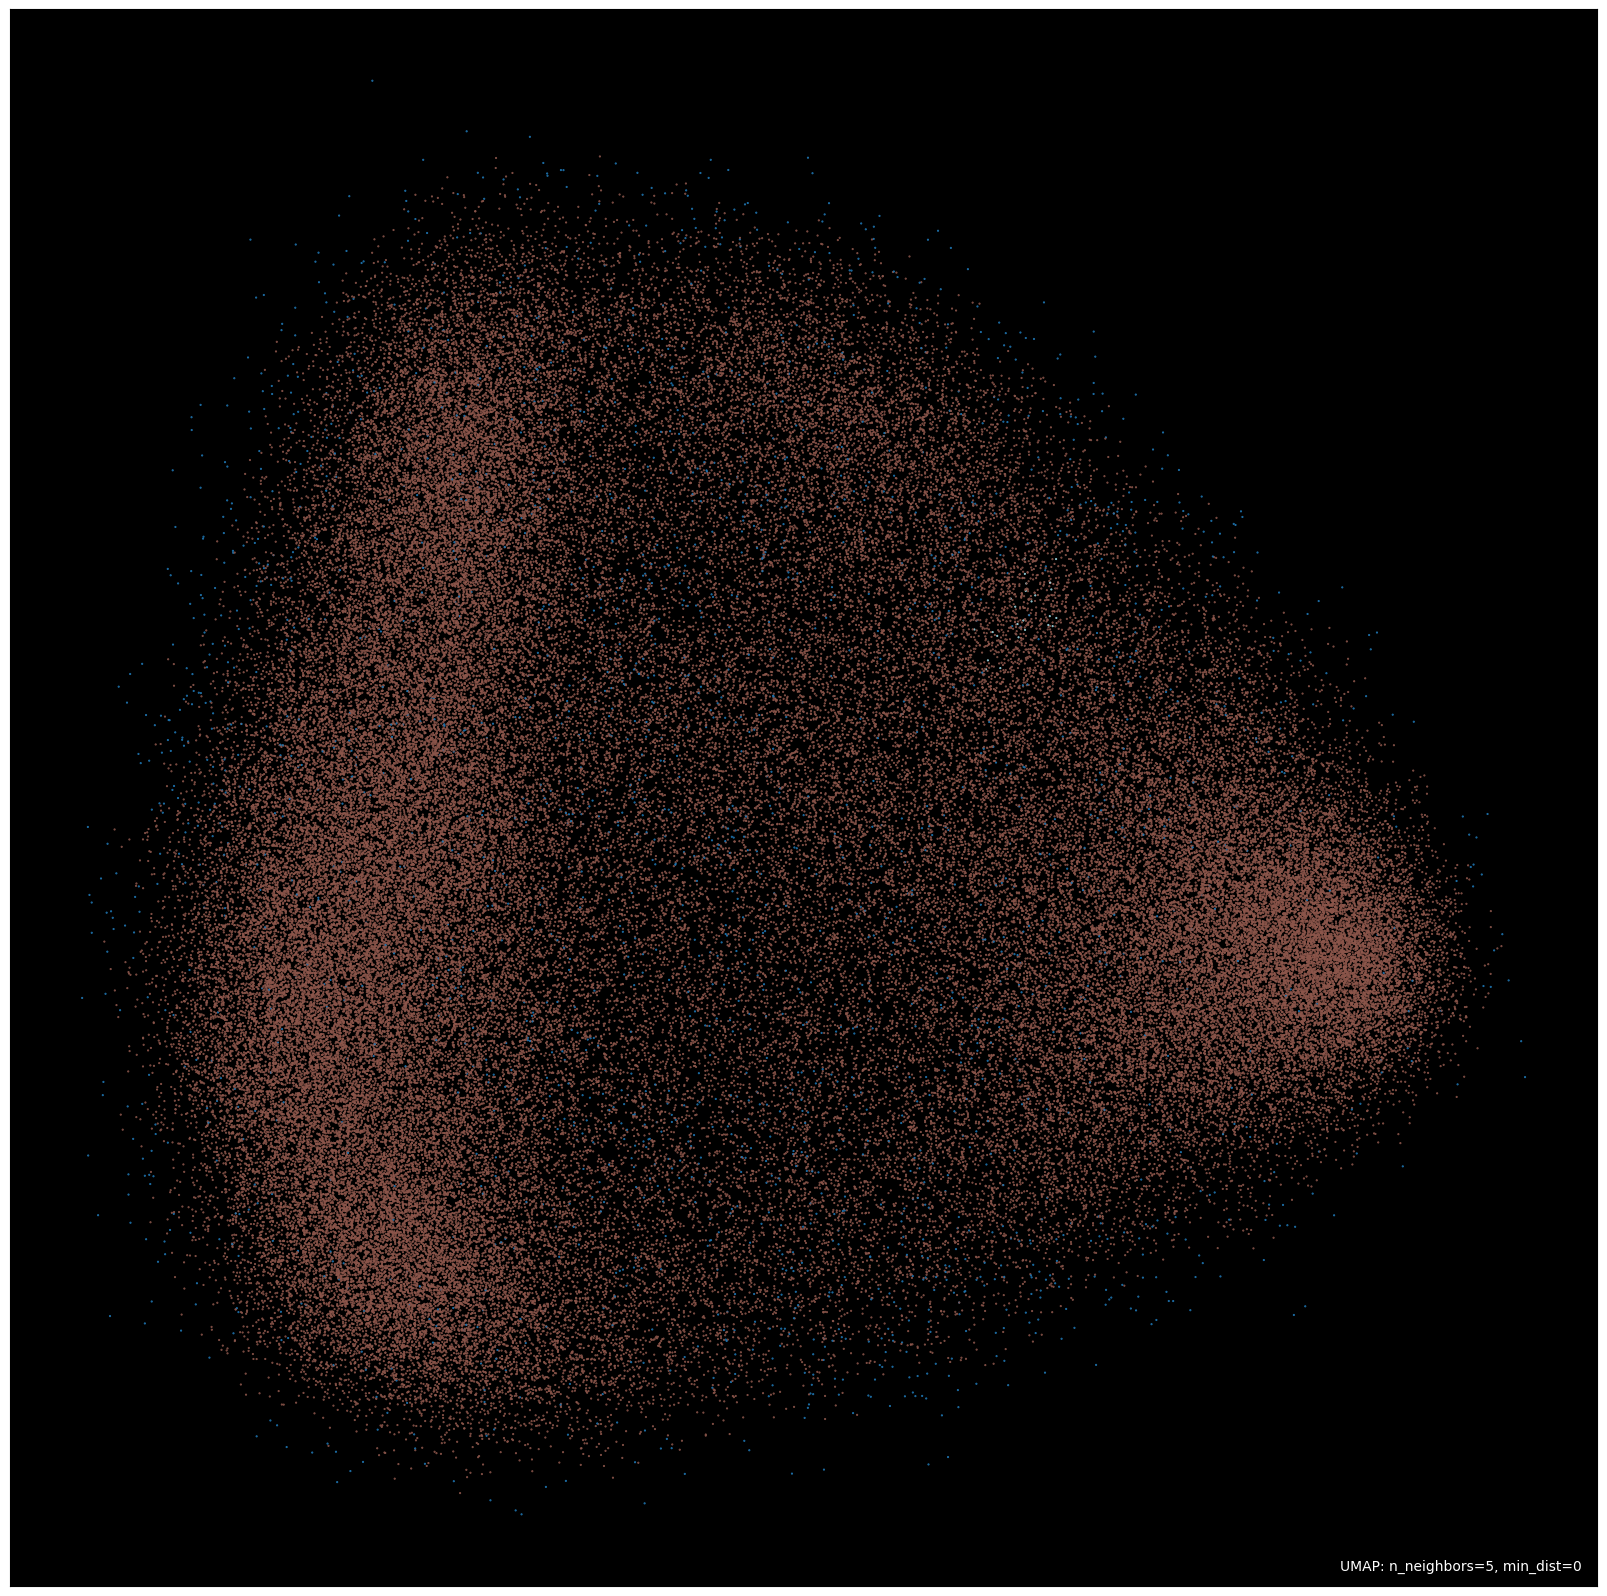

In [119]:
plot_it(res, get_colors(hdbscan.labels_))

In [26]:
from sklearn.cluster import KMeans

In [36]:
kmeans = KMeans(n_clusters=100, random_state=42)
kmeans_res = kmeans.fit(res_dimensional)

In [37]:
kmeans_res.labels_

array([97, 82, 22, ..., 20, 71, 50], dtype=int32)

<Axes: >

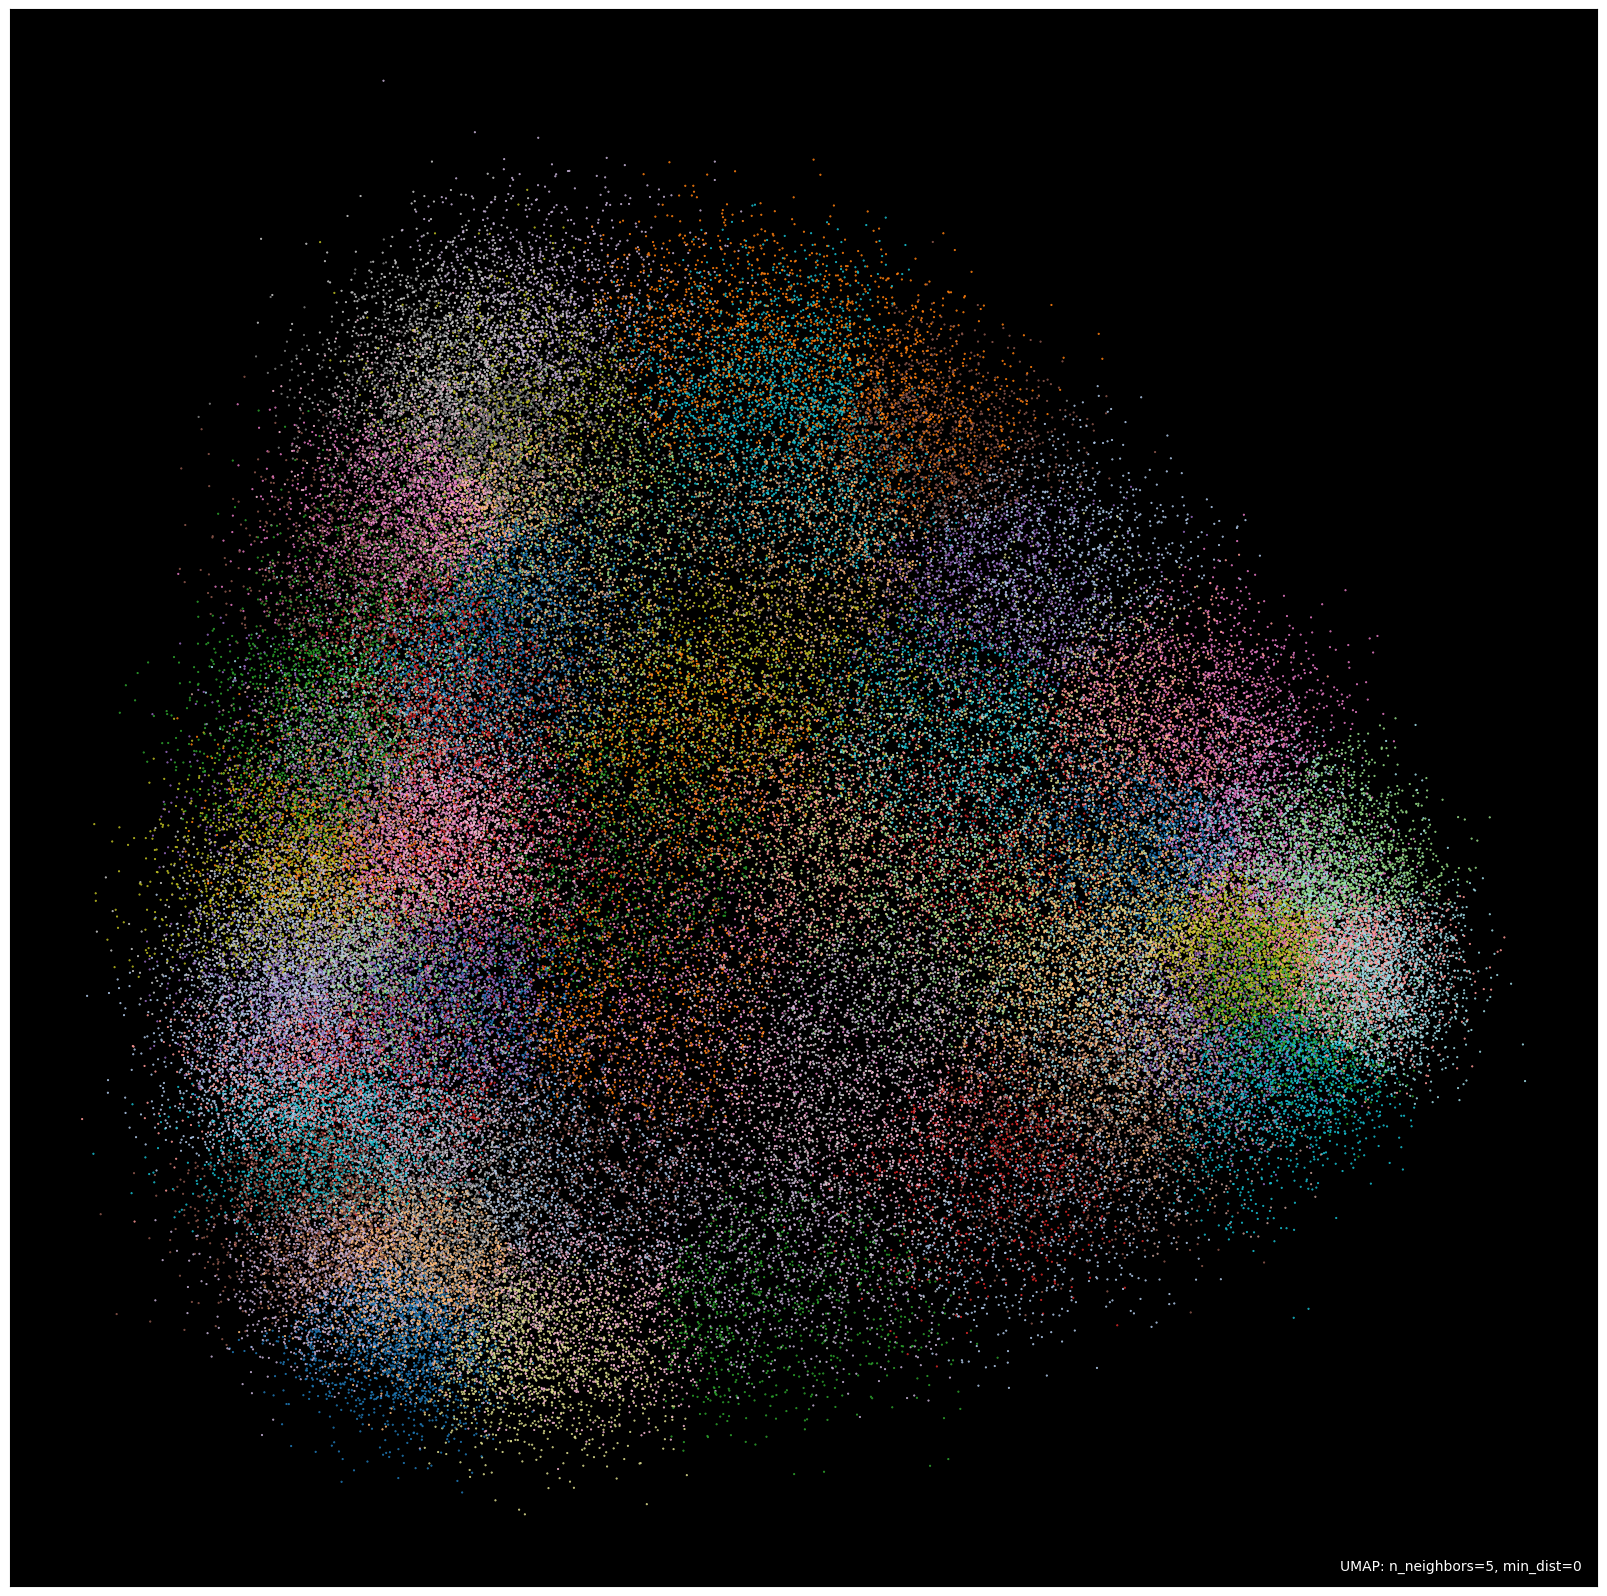

In [45]:
plot_it(res, get_colors(kmeans_res.labels_))

In [30]:
from datasets import load_dataset

In [31]:
ds = load_dataset("mwarchalowski/grants", "full_clean_emb_mapped")

In [52]:
shader_plot(res, kmeans_res.labels_)

ValueError: Insufficient colors provided (22) for the categorical fields available (100)